# Lesson learnt from Kaggle - Bengali Image Classification Competition
> Lesson learnt from kaggle competition
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [ml, Kaggle]
- image: images/bengali_00_header.png

I have recently team up with a friend to participate the [Bengali Image Classificaiton Competition](https://www.kaggle.com/c/bengaliai-cv19/?utm_medium=email&utm_source=intercom&utm_campaign=bengaliai-email-launch). The competition is tough, we struggled along the way and couldn't figure out why we cannot get a score that matching with others in the Public Leaderboard. In the end, the result is a big surprise to everyone as the leaderboard shaked heavily.

![Public Leaderboard](nb_img/bengali_0_public_lb.png "Public Leaderboard has much higher score, >0.99 recall!")

![Public Leaderboard](nb_img/bengali_1_private_lb.png "Note that the rank shaked for over 1000!")

It is interesting that the final score was much lower than the public leaderboard, it suggestes that most of the participant are highly overfitting the training data. 

# The Classification Task

The competition is about image classification of __Bengali__ characters,  which you can think of a more difficult __MNIST__ classification. It can be decompose into 3 parts, `root`, `consonant` and `vowel`, and our task is to classify them correctly.

![Grapheme example](nb_img/bengali_2_grapheme.png "Examples of characters")

## Evaluation Metrics
The competition use macro-recall as the evaluation metric. In general people get >96% recall in training, the tops are even getting >99% recall.

In [ ]:
# collapse-hide
```
python
import numpy as np
import sklearn.metrics

scores = []
for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
    y_true_subset = solution[solution[component] == component]['target'].values
    y_pred_subset = submission[submission[component] == component]['target'].values
    scores.append(sklearn.metrics.recall_score(
        y_true_subset, y_pred_subset, average='macro'))
final_score = np.average(scores, weights=[2,1,1])
```

## Model (Bigger still better)

We start with `xresnet50`, which is a relative small model. As we have the assumption that this classification task is a very standard task, therefore the difference of model will not be the most important one. Thus we pick xresnet50 as it have a good performance in terms of accuracy and train relatively fast. 

Near the end of the competition, we switch to a larger model `se-resnext101`. It require triple training time plus we have to scale down the batch size as it does not fit into the GPU memory. Surprisingly (maybe not surprise to everyone), bigger model did boost the performance more than I expected with \~0.3-0.5% recall. It is a big improvement as the recall is very high (\~0.97), in other words it reduce __\~10%__  error solely by just using a better model, not bad!

## Augmentation

There are never "enough" data for deep learning, so we always try our best to collect more data. Since we cannot collect more data, we need data augmentation.
We start with rotation + scale. We also find __MixUp__ and __CutMix__ is very effective to boost the performance. It also give us roughly __10%__ boost initially from 0.96 -> 0.964 recall.

### [CutMix](https://arxiv.org/abs/1905.04899) & [MixUp](https://arxiv.org/pdf/1710.09412.pdf)

![Example of Augmentation](nb_img/bengali_3_data_aug.png)

_Mixup_ is simple, if you know about photography, it is basically double exposure of your photos. It overlays two images (cat+dog in this case) by sampling weights. So instead of prediction P(dog) = 1, the new target could become P(dog) = 0.8 and P(cat) = 0.2.

_CutMix_ share similar idea, instead of overlay 2 images, it crop out a certain ratio of image and replace it with another one.

It always surprise me that these augmented data does not make much sense to human, but it is very effective to improve model accuracy and reduce overfitting emprically.

# Logging of Experiment

I normally just log my experiment with a simple csv and some printing message. This start to get tedious when there are more than 1 people to work. It is important to communicate experiments result. I explore `Hydra` and `wandb` in this competition and they are very useful.

## [Hydra](https://hydra.cc/)
![Hydra for configuration composition](nb_img/bengali_4_hydra.png)
It is often a good idea to make your experiment configurable. We use `Hydra` for this purpose and it is useful to compose different configuration group.
By making your hyper-paramters configurable, you can define an experiment by configuration file and run multiple experiments. By logging the configuration with the training statistics, it is easily to do cross model comparison and find out which configuration is useful for your model.

I have written [an short exmaple](https://mediumnok.ml/coding/ml/2020/02/08/Config-Composition-with-Hydra-for-Machine-Learning-Experiments.html) for how to use __Hydra__.

## [Wandb](https://www.wandb.com/)

__wandb__ (Weight & Biases) does a few things. It provide built-in function that automatcially log all your model statistics, while keeping it easy to log anything you want.

* Compare configuration of different experiments to find out the model with best performance.
* Built-in function for logging model weights and gradient for debugging purpose.
* Log any metrics that you want

All of these combined to make collaboration experience better. It is really important to sync the progress frequently, and getting everyone result in a single platform make these conversations easier.


![image.png](attachment:image.png "Screenshot of wandb UI for cross model comparison")
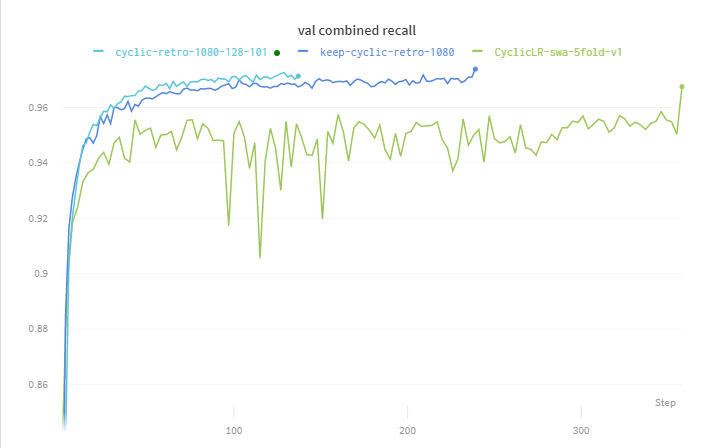

# [Stochastic Weight Averaging](https://pytorch.org/blog/stochastic-weight-averaging-in-pytorch/)
This is a simple yet effective technique which give about 0.3-0.4% boost to my model. In simple words, it takes snahpshot of the model weights during training and take an average at the end. It provides a cheap way to do model ensemble while you are only training 1 model. This is important for this competition as it allows me to keep training time short enough to allow feedback within hours and reduce overfitting.)



# ![image.png](attachment:image.png "Stochastic Weight Averaging")
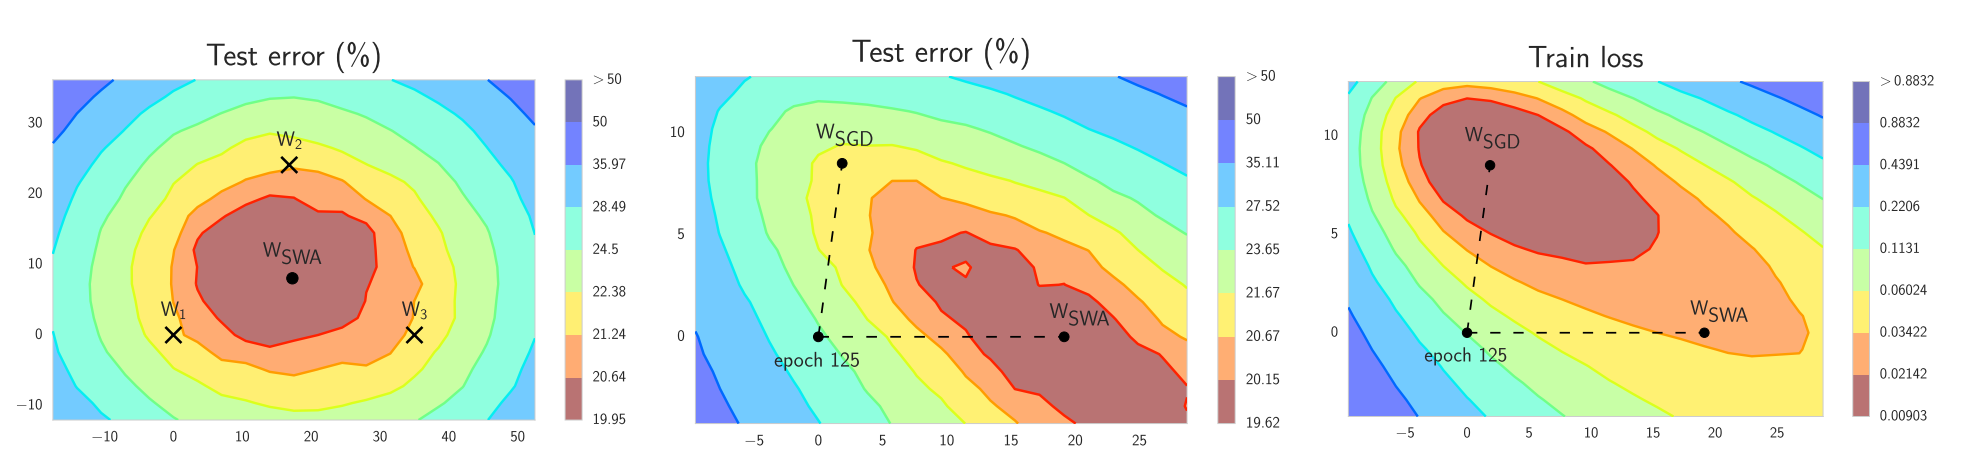

# Larger is better (image size)
We downsample our image size to 128x128 throughout the competition, as it makes model train faster and we believe most technique should be transferable to larger image size. It is important to keep your feedback loop short enough (hours if not days). You want your training data as small as possible, while keeping them transferable to your full dataset. Once we scale our image to full size, it takes almost 20 hours to train a single model, and we only have little chance to tune the hyper-parameters before the competition end.

# Debug & Checkpoint
There was a time we develop our model separately and we didn't sync our code for a while. We refactor our code during the time and it was a huge mistake. It turns out our pre-refactor code trains much better model and we introduce some unknown bug. It is almost impossible to find out as we changes multiple of things. It is so hard to debug a neural network and testing it throughly is important. Injecting a large amount of code may helps you to run an experiment earlier, but you may pay much more time to debug it afterward.

I think this is applicable even if you are working alone.
* Keep your changes small.
* Establish a baseline early, always do a regression test after a new features introduced (especially after code refactoring)
* Create checkpoint to rollback anytime, especially if you are not working on it every day.

Implementation is really the key of a competition (in real life too). It does not matter how great your model are, a tiny little bug could have damage your model silently


# Use auxiliary label
![image.png](attachment:image.png "The extra grapheme label")
As mentioned earlier, this competition requires to predict the `root`, `vowel` and the `consonant` part. In the training data, they actually provide the `grapheme` too. Lots of people saying that if you train with the `grapheme`, it improves the model greatly and get the recall >98% easily.

This is something we could not reproduce throughout the competition, we tried it in the very last minute but it does not seems to improve our model. It turns out lots of people are overfitting the data, as the testing dataset have much more unseen character.

But it is still a great remark that training with labels that is not your final desired output could still be very useful.
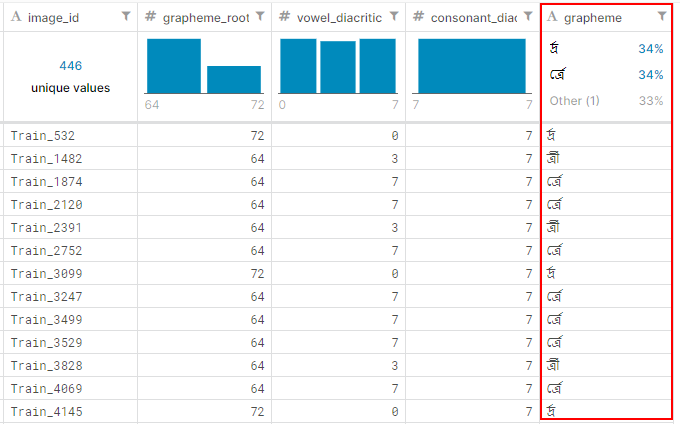

# Weight loss
The distribution of the training dataset is very imbalance, but in order to get a good result, we need to predict every single class accurately (macro recall). To deal with this issue, we choose to use class weights, where a higher weight would be apply to rare sample. We don't have an ablation study for this, but it seems to closen the gap between accuracy & recall, and allows us to train the model slightly better.

# Find a teammate!
Lastly, please go and find a teammate if you can. It is very common to start a Kaggle competition, but not so easy to finish them. I have stopped for a month during the competition due to my job. It is really hard to get back to the competition after you stopped for so long. Getting a teammate helps motivating you and at the end it is a great learning experience for both of us.

# Pretrain Model
We also tried to use pretrained model, as it allows shorter training and give better performance by transfer learning (Using weights learn from a large dataset to as initial weight). It also give our model a bit improvement. 

* Finetune the model head, while keeping other layers freeze (except BatchNorm layer).
* Unfreeze the model, train all the layers together.

I also tried training the model directly with discriminating learning rate while not freezing any layer at all. It seems to perform similarily, so I end up just start training the entire model from the beginning.

# If the code works, don't touch it
This is probably not a good habit usually, but I suggest not to do it for a competition. We spends lots of time for debugging our code after code refactoring, and end up just rolling back to an older commit and cherry-picks new features. In a competition, you don't have enough time to test everything. You do not need a nice abstract class for all your features, some refactoring to keep your function/class clean is probably needed, but do not over spend your time on it. It is even common to jump between frameworks (you may find other's Kernel useful), so it is not possible structure your code perfectly.

* If someone have create a working submission script, use it!
* If someone have create a working pre-processing function, use it!

Don't spend time on trying to optimize these code unless it is neccessary, it is often not worth it in a competition context. You should focus on adding new features, trying out new model, testing with new augmentation technique instead.

# Summary
This is a great learning experience and refresh some of my outdated computer vision model knowledge. If you have never join a competition, find a friend and get started. If you have just finished one, try writing it out and share your experience. 😉